![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

<div class="alert alert-warning">
This notebook still needs to go through revision.
</div>

# Analysis of PIV data

TODO: add some description here
- what was investigated; experimental setup, research project, links
- how the data was preprocessed/exported from DaVis
- give the notebook a more descriptive name and title

In [1]:
import torch as pt
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch.data import CSVDataloader
from flowtorch.data.utils import format_byte_size
from flowtorch.analysis.svd import SVD
from flowtorch.analysis.dmd import DMD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Assembling the data matrix

crop field; zero values not bad for x and y component but visualization of z is tricky (-50 average); measure min and max of x and y

In [2]:
path = "../../../test/test_data/external_data/AoA8_beta0_xc100_StereoPIV/"
loader = CSVDataloader.from_davis(path, prefix="B")
times = loader.write_times()
fields = loader.field_names()[times[0]]
vertices = loader.get_vertices()
print(f"First and last snapshot: {times[0]}/{times[-1]}")
print("Available fields: ", fields)
print(f"Available measurement points: {vertices.shape[0]}")

First and last snapshot: 00001/05000
Available fields:  ['Vx', 'Vy', 'Vz']
Available measurement points: 3741


In [22]:
data_matrix = pt.zeros((vertices.shape[0]*3, len(times)), dtype=pt.float32)
for i, time in enumerate(times):
    data_matrix[:, i] = loader.load_snapshot(fields, time).T.flatten()
    
size = data_matrix.nelement() * data_matrix.element_size()
print("The data matrix requires approximately {:2.2f} {:s} of memory.".format(*format_byte_size(size)))

The data matrix requires approximately 214.06 Mb of memory.


## Flow field analysis
### Mean and variance
First we look at the spatial mean over time (the mean velocity over all measurement points in a snapshot) and then we examine the temporal mean in each measurement points.

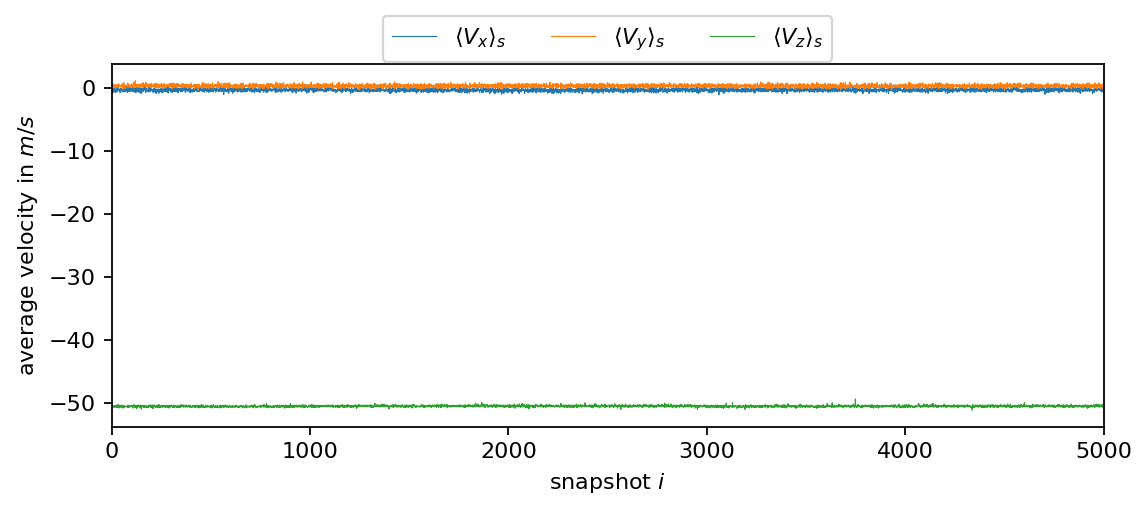

In [23]:
np = vertices.shape[0]
spatial_mean_Vx = pt.mean(data_matrix[:np, :], dim=0)
spatial_mean_Vy = pt.mean(data_matrix[np:2*np, :], dim=0)
spatial_mean_Vz = pt.mean(data_matrix[2*np:, :], dim=0)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(range(len(times)), spatial_mean_Vx, lw=0.5, label=r"$\langle V_x \rangle_s$")
ax.plot(range(len(times)), spatial_mean_Vy, lw=0.5, label=r"$\langle V_y \rangle_s$")
ax.plot(range(len(times)), spatial_mean_Vz, lw=0.5, label=r"$\langle V_z \rangle_s$")
ax.set_xlim(0, len(times))
ax.set_xlabel(r"snapshot $i$")
ax.set_ylabel(r"average velocity in $m/s$")
ax.legend(bbox_to_anchor=(0.5, 1.07), loc="center", ncol=3)
plt.show()

In [24]:
def color_bounds(field, factor):
    mean = pt.mean(field)
    std = pt.std(field)
    return {"vmin" : mean-factor*std,
            "vmax" : mean+factor*std}

def add_velocity_to_axes(ax1, ax2, ax3, vertices, field, factor):
    np = vertices.shape[0]
    ux = field[:np]
    std_ux = pt.std(ux)
    mean_ux = pt.mean(ux)
    tri = []
    tri.append(ax1.tricontourf(vertices[:, 0], vertices[:, 1], field[:np], levels=15, cmap="jet", **color_bounds(field[:np], factor)))
    tri.append(ax2.tricontourf(vertices[:, 0], vertices[:, 1], field[np:2*np], levels=15, cmap="jet", **color_bounds(field[np:2*np], factor)))
    tri.append(ax3.tricontourf(vertices[:, 0], vertices[:, 1], field[2*np:], levels=15, cmap="jet", **color_bounds(field[2*np:], factor)))
    ax1.set_ylabel(r"$y$")
    for ax, tri in zip([ax1, ax2, ax3], tri):
        ax.set_aspect("equal", 'box')
        cbar = plt.colorbar(tri, ax=ax, orientation="horizontal")
        cbar.ax.tick_params(labelsize=8)

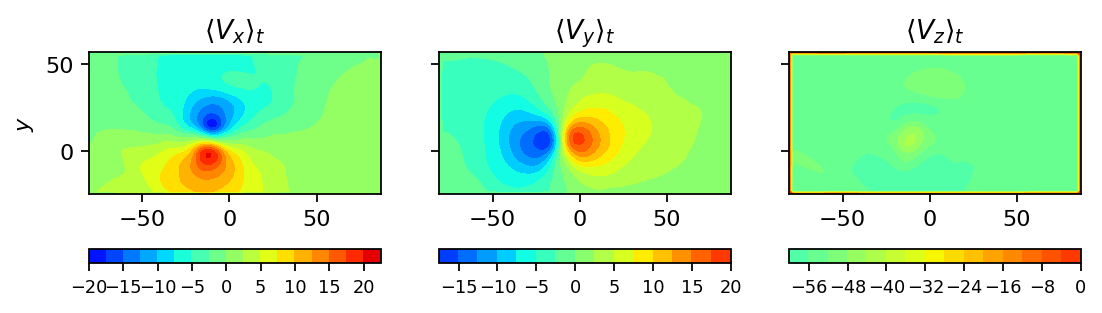

In [27]:
temporal_mean = pt.mean(data_matrix, dim=1)
fig, axarr = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
add_velocity_to_axes(*axarr, vertices, temporal_mean, 5)
titles = [r"$\langle V_x \rangle_t$", r"$\langle V_y \rangle_t$", r"$\langle V_z \rangle_t$"]
for ax, title in zip(axarr, titles):
    ax.set_title(title)
plt.show()

In [21]:
test = pt.tensor([[1, 2], [3, 4], [5, 6]])
test.T.flatten()

tensor([1, 3, 5, 2, 4, 6])